In [1]:
import os
import tarfile
import urllib.request

DOWNLOAD_ROOT = "https://raw.githubusercontent.com/ageron/handson-ml2/master/"
HOUSING_URL = DOWNLOAD_ROOT + "datasets/housing/housing.tgz"
HOUSING_PATH = os.path.join("E:", "HVintroductionToAIAndMachinLearning", "housingDataSet")

def fetch_housing_data(housing_url=HOUSING_URL, housing_path=HOUSING_PATH):
    if not os.path.isdir(housing_path):
        os.makedirs(housing_path)
    tgz_path = os.path.join(housing_path, "housing.tgz")
    urllib.request.urlretrieve(housing_url, tgz_path)
    housing_tgz = tarfile.open(tgz_path)
    housing_tgz.extractall(path=housing_path)
    housing_tgz.close()

In [2]:
fetch_housing_data()

C:\Users\OMID\AppData\Local\Temp\ipykernel_11540\684986203.py:15: DeprecationWarning: Python 3.14 will, by default, filter extracted tar archives and reject files or modify their metadata. Use the filter argument to control this behavior.
  housing_tgz.extractall(path=housing_path)


In [3]:
import pandas as pd

def load_housing_data(housing_path=HOUSING_PATH):
    csv_path = os.path.join(housing_path, "housing.csv")
    return pd.read_csv(csv_path)

In [4]:
housing = load_housing_data()
housing.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [5]:
housing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


In [6]:
corr_matrix = housing.drop("ocean_proximity", axis=1).corr()

In [7]:
corr_matrix["median_house_value"].sort_values(ascending=False)

median_house_value    1.000000
median_income         0.688075
total_rooms           0.134153
housing_median_age    0.105623
households            0.065843
total_bedrooms        0.049686
population           -0.024650
longitude            -0.045967
latitude             -0.144160
Name: median_house_value, dtype: float64

In [8]:
import numpy as np

housing["income_cat"] = pd.cut(housing["median_income"], bins=[0., 1.5, 3.0, 4.5, 6., np.inf], labels=[1, 2, 3, 4, 5])

In [9]:
from sklearn.model_selection import StratifiedShuffleSplit

split_obj = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in split_obj.split(housing, housing["income_cat"]):
    strat_train_set = housing.loc[train_index]
    strat_test_set = housing.loc[test_index]

In [10]:
for set_ in (strat_train_set, strat_test_set):
    set_.drop("income_cat", axis=1, inplace=True)

In [11]:
housing_features = strat_train_set.drop("median_house_value", axis=1)
housing_labels = strat_train_set["median_house_value"].copy()

In [12]:
housing_features_num = housing_features.drop("ocean_proximity", axis=1)

In [13]:
from sklearn.base import BaseEstimator, TransformerMixin

# column index
rooms_ix, bedrooms_ix, population_ix, households_ix = 3, 4, 5, 6

class CombinedAttributesAdder(BaseEstimator, TransformerMixin):
    def __init__(self, add_bedrooms_per_room=True): # no *args or **kargs
        self.add_bedrooms_per_room = add_bedrooms_per_room
    def fit(self, X, y=None):
        return self  # nothing else to do
    def transform(self, X):
        rooms_per_household = X[:, rooms_ix] / X[:, households_ix]
        population_per_household = X[:, population_ix] / X[:, households_ix]
        if self.add_bedrooms_per_room:
            bedrooms_per_room = X[:, bedrooms_ix] / X[:, rooms_ix]
            return np.c_[X, rooms_per_household, population_per_household,
                         bedrooms_per_room]
        else:
            return np.c_[X, rooms_per_household, population_per_household]

In [14]:
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler

pipeline = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("attr_adder", CombinedAttributesAdder()),
    ("std_scaler", StandardScaler())
])

In [15]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder

num_attribs = list(housing_features_num)
cat_attribs = ["ocean_proximity"]

full_pipeline = ColumnTransformer([
        ("num", pipeline, num_attribs),
        ("cat", OneHotEncoder(), cat_attribs),
    ])

housing_prepared = full_pipeline.fit_transform(housing_features)

In [16]:
housing_prepared

array([[-0.94135046,  1.34743822,  0.02756357, ...,  0.        ,
         0.        ,  0.        ],
       [ 1.17178212, -1.19243966, -1.72201763, ...,  0.        ,
         0.        ,  1.        ],
       [ 0.26758118, -0.1259716 ,  1.22045984, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [-1.5707942 ,  1.31001828,  1.53856552, ...,  0.        ,
         0.        ,  0.        ],
       [-1.56080303,  1.2492109 , -1.1653327 , ...,  0.        ,
         0.        ,  0.        ],
       [-1.28105026,  2.02567448, -0.13148926, ...,  0.        ,
         0.        ,  0.        ]])

In [17]:
housing_prepared.shape

(16512, 16)

In [18]:
from sklearn.linear_model import LinearRegression

lin_reg = LinearRegression()
lin_reg.fit(housing_prepared, housing_labels)

LinearRegression()

In [19]:
from sklearn.metrics import root_mean_squared_error

housing_predictions = lin_reg.predict(housing_prepared)
lin_rmse = root_mean_squared_error(housing_labels, housing_predictions)

In [20]:
lin_rmse

68627.87390018745

In [21]:
from sklearn.tree import DecisionTreeRegressor

tree_reg = DecisionTreeRegressor(random_state=42)
tree_reg.fit(housing_prepared, housing_labels)

DecisionTreeRegressor(random_state=42)

In [22]:
housing_predictions = tree_reg.predict(housing_prepared)
tree_rmse = root_mean_squared_error(housing_labels, housing_predictions)

In [23]:
tree_rmse

0.0

In [24]:
from sklearn.ensemble import RandomForestRegressor

forest_reg = RandomForestRegressor(n_estimators=100, random_state=42)
forest_reg.fit(housing_prepared, housing_labels)

RandomForestRegressor(random_state=42)

In [25]:
housing_predictions = forest_reg.predict(housing_prepared)
forest_rmse = root_mean_squared_error(housing_labels, housing_predictions)

In [26]:
forest_rmse

18650.698705770003

In [27]:
from sklearn.model_selection import cross_val_score

tree_scores = cross_val_score(tree_reg, housing_prepared, housing_labels, scoring="neg_mean_squared_error", cv=10)
tree_rmse_scores = np.sqrt(-tree_scores)
lin_scores = cross_val_score(lin_reg, housing_prepared, housing_labels, scoring="neg_mean_squared_error", cv=10)
lin_rmse_scores = np.sqrt(-lin_scores)
forest_scores = cross_val_score(forest_reg, housing_prepared, housing_labels, scoring="neg_mean_squared_error", cv=10)
forest_rmse_scores = np.sqrt(-forest_scores)

In [28]:
def display_scores(scores):
    print("Scores:", scores)
    print("Mean:", scores.mean())
    print("Standard deviation:", scores.std())

In [29]:
display_scores(lin_rmse_scores)

Scores: [71762.76364394 64114.99166359 67771.17124356 68635.19072082
 66846.14089488 72528.03725385 73997.08050233 68802.33629334
 66443.28836884 70139.79923956]
Mean: 69104.07998247063
Standard deviation: 2880.3282098180657


In [30]:
display_scores(tree_rmse_scores)

Scores: [72831.45749112 69973.18438322 69528.56551415 72517.78229792
 69145.50006909 79094.74123727 68960.045444   73344.50225684
 69826.02473916 71077.09753998]
Mean: 71629.89009727491
Standard deviation: 2914.035468468928


In [31]:
display_scores(forest_rmse_scores)

Scores: [51559.63379638 48737.57100062 47210.51269766 51875.21247297
 47577.50470123 51863.27467888 52746.34645573 50065.1762751
 48664.66818196 54055.90894609]
Mean: 50435.58092066179
Standard deviation: 2203.3381412764606


In [35]:
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeRegressor

param_grid = [
    {'max_depth': [3, 10, 30, 70, 100], 'min_samples_split': [2, 5, 10]},
    {'max_depth': [3, 30, 70, 100], 'min_samples_split': [2, 10, 20]},
    {'max_depth': [3, 30, 70], 'min_samples_split': [2, 5], 'min_samples_leaf': [1, 2, 5, 10, 30, 50]}
]

tree_reg = DecisionTreeRegressor(random_state=42)
tree_grid_search = GridSearchCV(tree_reg, param_grid, cv=5, scoring='neg_mean_squared_error', return_train_score=True)
tree_grid_search.fit(housing_prepared, housing_labels)

GridSearchCV(cv=5, estimator=DecisionTreeRegressor(random_state=42),
             param_grid=[{'max_depth': [3, 10, 30, 70, 100],
                          'min_samples_split': [2, 5, 10]},
                         {'max_depth': [3, 30, 70, 100],
                          'min_samples_split': [2, 10, 20]},
                         {'max_depth': [3, 30, 70],
                          'min_samples_leaf': [1, 2, 5, 10, 30, 50],
                          'min_samples_split': [2, 5]}],
             return_train_score=True, scoring='neg_mean_squared_error')

In [36]:
tree_grid_search.best_params_

{'max_depth': 30, 'min_samples_leaf': 30, 'min_samples_split': 2}

In [37]:
cvres = tree_grid_search.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(np.sqrt(-mean_score), params)

75687.40458065865 {'max_depth': 3, 'min_samples_split': 2}
75687.40458065865 {'max_depth': 3, 'min_samples_split': 5}
75687.40458065865 {'max_depth': 3, 'min_samples_split': 10}
62739.780496000894 {'max_depth': 10, 'min_samples_split': 2}
62245.87069019278 {'max_depth': 10, 'min_samples_split': 5}
62056.24290857084 {'max_depth': 10, 'min_samples_split': 10}
71164.68031890217 {'max_depth': 30, 'min_samples_split': 2}
69036.40841975668 {'max_depth': 30, 'min_samples_split': 5}
66550.26509797896 {'max_depth': 30, 'min_samples_split': 10}
70911.53911695824 {'max_depth': 70, 'min_samples_split': 2}
68813.57786263606 {'max_depth': 70, 'min_samples_split': 5}
66569.9365618405 {'max_depth': 70, 'min_samples_split': 10}
70911.53911695824 {'max_depth': 100, 'min_samples_split': 2}
68813.57786263606 {'max_depth': 100, 'min_samples_split': 5}
66569.9365618405 {'max_depth': 100, 'min_samples_split': 10}
75687.40458065865 {'max_depth': 3, 'min_samples_split': 2}
75687.40458065865 {'max_depth': 3, 'm

In [38]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint

param_distribs = {
    'max_depth': randint(low=1, high=100),
    'min_samples_split': randint(low=2, high=20),
    'min_samples_leaf': randint(low=1, high=50)
}

tree_reg = DecisionTreeRegressor(random_state=42)
tree_rnd_search = RandomizedSearchCV(tree_reg, param_distributions=param_distribs, n_iter=20, cv=5, scoring='neg_mean_squared_error', random_state=42)
tree_rnd_search.fit(housing_prepared, housing_labels)

RandomizedSearchCV(cv=5, estimator=DecisionTreeRegressor(random_state=42),
                   n_iter=20,
                   param_distributions={'max_depth': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x000001802CD16AB0>,
                                        'min_samples_leaf': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x000001802CD513D0>,
                                        'min_samples_split': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x000001802D1C66F0>},
                   random_state=42, scoring='neg_mean_squared_error')

In [39]:
tree_rnd_search.best_params_

{'max_depth': 92, 'min_samples_leaf': 16, 'min_samples_split': 16}

In [40]:
cvres = tree_rnd_search.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(np.sqrt(-mean_score), params)

59167.710870384144 {'max_depth': 52, 'min_samples_leaf': 29, 'min_samples_split': 16}
59098.7462136198 {'max_depth': 72, 'min_samples_leaf': 21, 'min_samples_split': 8}
59212.88557235138 {'max_depth': 83, 'min_samples_leaf': 23, 'min_samples_split': 12}
59265.22597726354 {'max_depth': 75, 'min_samples_leaf': 24, 'min_samples_split': 5}
65583.6654421473 {'max_depth': 24, 'min_samples_leaf': 3, 'min_samples_split': 3}
59516.466906993715 {'max_depth': 88, 'min_samples_leaf': 44, 'min_samples_split': 7}
82843.87365364736 {'max_depth': 2, 'min_samples_leaf': 21, 'min_samples_split': 2}
59204.56241153977 {'max_depth': 76, 'min_samples_leaf': 22, 'min_samples_split': 13}
59797.212965091196 {'max_depth': 89, 'min_samples_leaf': 49, 'min_samples_split': 11}
58907.789487787726 {'max_depth': 92, 'min_samples_leaf': 16, 'min_samples_split': 16}
59761.90911846026 {'max_depth': 62, 'min_samples_leaf': 47, 'min_samples_split': 13}
65701.53792009932 {'max_depth': 55, 'min_samples_leaf': 3, 'min_sample

In [41]:
param_grid = [
    {'n_estimators': [3, 10, 30], 'max_features': [2, 4, 6, 8], 'min_samples_leaf': [1, 3, 10]},
    {'bootstrap': [False], 'n_estimators': [3, 10], 'max_features': [2, 3, 4], 'min_samples_leaf': [1, 3, 10]}
]

forest_reg = RandomForestRegressor(random_state=42)
forest_grid_search = GridSearchCV(forest_reg, param_grid, cv=5, scoring='neg_mean_squared_error', return_train_score=True)
forest_grid_search.fit(housing_prepared, housing_labels)

GridSearchCV(cv=5, estimator=RandomForestRegressor(random_state=42),
             param_grid=[{'max_features': [2, 4, 6, 8],
                          'min_samples_leaf': [1, 3, 10],
                          'n_estimators': [3, 10, 30]},
                         {'bootstrap': [False], 'max_features': [2, 3, 4],
                          'min_samples_leaf': [1, 3, 10],
                          'n_estimators': [3, 10]}],
             return_train_score=True, scoring='neg_mean_squared_error')

In [42]:
forest_grid_search.best_params_

{'max_features': 8, 'min_samples_leaf': 3, 'n_estimators': 30}

In [43]:
cvres = forest_grid_search.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(np.sqrt(-mean_score), params)

63895.161577951665 {'max_features': 2, 'min_samples_leaf': 1, 'n_estimators': 3}
54916.32386349543 {'max_features': 2, 'min_samples_leaf': 1, 'n_estimators': 10}
52885.86715332332 {'max_features': 2, 'min_samples_leaf': 1, 'n_estimators': 30}
62174.24952542787 {'max_features': 2, 'min_samples_leaf': 3, 'n_estimators': 3}
55607.24330544387 {'max_features': 2, 'min_samples_leaf': 3, 'n_estimators': 10}
53812.82615525508 {'max_features': 2, 'min_samples_leaf': 3, 'n_estimators': 30}
62526.212581931664 {'max_features': 2, 'min_samples_leaf': 10, 'n_estimators': 3}
57208.69160815379 {'max_features': 2, 'min_samples_leaf': 10, 'n_estimators': 10}
56523.409597792226 {'max_features': 2, 'min_samples_leaf': 10, 'n_estimators': 30}
60075.3680329983 {'max_features': 4, 'min_samples_leaf': 1, 'n_estimators': 3}
52495.01284985185 {'max_features': 4, 'min_samples_leaf': 1, 'n_estimators': 10}
50187.24324926565 {'max_features': 4, 'min_samples_leaf': 1, 'n_estimators': 30}
57900.36844549329 {'max_fea

In [44]:
param_distribs = {
    'n_estimators': randint(low=1, high=200),
    'max_features': randint(low=1, high=8),
    'min_samples_leaf': randint(low=1, high=10)
}

forest_reg = RandomForestRegressor(random_state=42)
forest_rnd_search = RandomizedSearchCV(forest_reg, param_distributions=param_distribs, n_iter=20, cv=5, scoring='neg_mean_squared_error', random_state=42)
forest_rnd_search.fit(housing_prepared, housing_labels)

RandomizedSearchCV(cv=5, estimator=RandomForestRegressor(random_state=42),
                   n_iter=20,
                   param_distributions={'max_features': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x000001802D1FEF90>,
                                        'min_samples_leaf': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x000001802D1FEE70>,
                                        'n_estimators': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x000001802D1FCF50>},
                   random_state=42, scoring='neg_mean_squared_error')

In [45]:
forest_rnd_search.best_params_

{'max_features': 7, 'min_samples_leaf': 2, 'n_estimators': 132}

In [46]:
np.sqrt(-forest_rnd_search.best_score_)

49248.87568546681

In [47]:
cvres = forest_rnd_search.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(np.sqrt(-mean_score), params)

49865.81097769558 {'max_features': 7, 'min_samples_leaf': 4, 'n_estimators': 93}
50851.25133965564 {'max_features': 7, 'min_samples_leaf': 8, 'n_estimators': 189}
51080.658641613045 {'max_features': 5, 'min_samples_leaf': 7, 'n_estimators': 122}
52734.007642310025 {'max_features': 3, 'min_samples_leaf': 7, 'n_estimators': 75}
53127.80237116711 {'max_features': 3, 'min_samples_leaf': 8, 'n_estimators': 117}
51715.14219463711 {'max_features': 4, 'min_samples_leaf': 8, 'n_estimators': 152}
52505.81911112446 {'max_features': 3, 'min_samples_leaf': 6, 'n_estimators': 53}
55366.898029120835 {'max_features': 2, 'min_samples_leaf': 8, 'n_estimators': 158}
49368.218190260544 {'max_features': 6, 'min_samples_leaf': 2, 'n_estimators': 192}
50742.924548090064 {'max_features': 4, 'min_samples_leaf': 5, 'n_estimators': 161}
51130.59183782121 {'max_features': 4, 'min_samples_leaf': 6, 'n_estimators': 89}
59399.12984434357 {'max_features': 1, 'min_samples_leaf': 3, 'n_estimators': 108}
49960.160190380

In [48]:
param_grid = [
    {'kernel': ['linear'], 'C': [10., 30., 100., 300., 1000., 3000., 10000., 30000.0]},
    {'kernel': ['rbf'], 'C': [1.0, 3.0, 10., 30., 100., 300., 1000.0], 'gamma': [0.01, 0.03, 0.1, 0.3, 1.0, 3.0]}
]

svm_reg = SVR()
svm_grid_search = GridSearchCV(svm_reg, param_grid, cv=5, scoring='neg_mean_squared_error', verbose=2)
svm_grid_search.fit(housing_prepared, housing_labels)

Fitting 5 folds for each of 50 candidates, totalling 250 fits
[CV] END ..............................C=10.0, kernel=linear; total time=   8.7s
[CV] END ..............................C=10.0, kernel=linear; total time=   8.4s
[CV] END ..............................C=10.0, kernel=linear; total time=   8.5s
[CV] END ..............................C=10.0, kernel=linear; total time=   8.9s
[CV] END ..............................C=10.0, kernel=linear; total time=   8.5s
[CV] END ..............................C=30.0, kernel=linear; total time=   9.6s
[CV] END ..............................C=30.0, kernel=linear; total time=  10.2s
[CV] END ..............................C=30.0, kernel=linear; total time=   9.1s
[CV] END ..............................C=30.0, kernel=linear; total time=   9.1s
[CV] END ..............................C=30.0, kernel=linear; total time=   9.5s
[CV] END .............................C=100.0, kernel=linear; total time=   8.8s
[CV] END .............................C=100.0, 

GridSearchCV(cv=5, estimator=SVR(),
             param_grid=[{'C': [10.0, 30.0, 100.0, 300.0, 1000.0, 3000.0,
                                10000.0, 30000.0],
                          'kernel': ['linear']},
                         {'C': [1.0, 3.0, 10.0, 30.0, 100.0, 300.0, 1000.0],
                          'gamma': [0.01, 0.03, 0.1, 0.3, 1.0, 3.0],
                          'kernel': ['rbf']}],
             scoring='neg_mean_squared_error', verbose=2)

In [49]:
negative_mse = svm_grid_search.best_score_
rmse = np.sqrt(-negative_mse)
rmse

70286.61836530612

In [50]:
svm_grid_search.best_params_

{'C': 30000.0, 'kernel': 'linear'}

In [51]:
from scipy.stats import expon, reciprocal

# Note: gamma is ignored when kernel is "linear"
param_distribs = {
        'kernel': ['linear', 'rbf'],
        'C': reciprocal(20, 200000),
        'gamma': expon(scale=1.0),
    }

svm_reg = SVR()
svm_rnd_search = RandomizedSearchCV(svm_reg, param_distributions=param_distribs, n_iter=50, cv=5, scoring='neg_mean_squared_error', verbose=2, random_state=42)
svm_rnd_search.fit(housing_prepared, housing_labels)

Fitting 5 folds for each of 50 candidates, totalling 250 fits
[CV] END C=629.7823295913721, gamma=3.010121430917521, kernel=linear; total time=   8.8s
[CV] END C=629.7823295913721, gamma=3.010121430917521, kernel=linear; total time=   9.1s
[CV] END C=629.7823295913721, gamma=3.010121430917521, kernel=linear; total time=   8.6s
[CV] END C=629.7823295913721, gamma=3.010121430917521, kernel=linear; total time=   9.1s
[CV] END C=629.7823295913721, gamma=3.010121430917521, kernel=linear; total time=   9.1s
[CV] END C=26290.20646430022, gamma=0.9084469696321253, kernel=rbf; total time=  19.6s
[CV] END C=26290.20646430022, gamma=0.9084469696321253, kernel=rbf; total time=  19.7s
[CV] END C=26290.20646430022, gamma=0.9084469696321253, kernel=rbf; total time=  20.4s
[CV] END C=26290.20646430022, gamma=0.9084469696321253, kernel=rbf; total time=  20.1s
[CV] END C=26290.20646430022, gamma=0.9084469696321253, kernel=rbf; total time=  20.0s
[CV] END C=84.14107900575871, gamma=0.059838768608680676, 

RandomizedSearchCV(cv=5, estimator=SVR(), n_iter=50,
                   param_distributions={'C': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x000001802D1CD550>,
                                        'gamma': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x000001802CD50D10>,
                                        'kernel': ['linear', 'rbf']},
                   random_state=42, scoring='neg_mean_squared_error',
                   verbose=2)

In [52]:
svm_rnd_search.best_params_

{'C': 157055.10989448498, 'gamma': 0.26497040005002437, 'kernel': 'rbf'}

In [53]:
negative_mse = svm_rnd_search.best_score_
rmse = np.sqrt(-negative_mse)
rmse

54751.69009256622

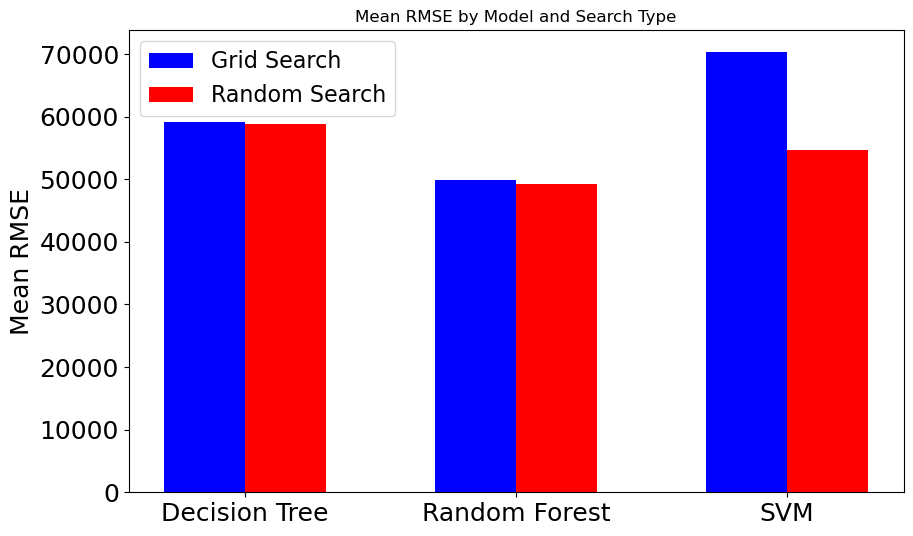

In [159]:
import matplotlib.pyplot as plt

tuning_objs = {
    'Decision Tree': {
        'grid_search': tree_grid_search,
        'random_search': tree_rnd_search
    },
    'Random Forest': {
        'grid_search': forest_grid_search,
        'random_search': forest_rnd_search
    },
    'SVM': {
        'grid_search': svm_grid_search,
        'random_search': svm_rnd_search
    }
}

models = list(tuning_objs.keys())
rmse_values = {
    'Grid Search': [],
    'Random Search': []
}

for model in models:
    rmse_values['Grid Search'].append(np.sqrt(-tuning_objs[model]['grid_search'].best_score_))
    rmse_values['Random Search'].append(np.sqrt(-tuning_objs[model]['random_search'].best_score_))

x = np.arange(len(models))
width = 0.3

fig, ax = plt.subplots(figsize=(10, 6))

bars1 = ax.bar(x - width/2, rmse_values['Grid Search'], width, label='Grid Search', color='b')
bars2 = ax.bar(x + width/2, rmse_values['Random Search'], width, label='Random Search', color='r')

ax.set_xticks(x)
ax.set_xticklabels(models, fontsize=18)

ax.set_ylabel('Mean RMSE', fontsize=18)
ax.tick_params(axis='y', labelsize=18)
ax.set_title('Mean RMSE by Model and Search Type')
ax.legend(fontsize=16)

plt. savefig('rmse_comparison_plot.png')
plt.show()

In [155]:
final_model = forest_rnd_search.best_estimator_

X_test = strat_test_set.drop("median_house_value", axis=1)
y_test = strat_test_set["median_house_value"].copy()

X_test_prepared = full_pipeline.transform(X_test)
final_predictions = final_model.predict(X_test_prepared)

final_rmse = root_mean_squared_error(y_test, final_predictions)

In [157]:
final_rmse

46763.450401005975